In [1]:
%load_ext autoreload
%autoreload 2
import lusee
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 3.5]
matplotlib.rcParams['figure.dpi'] = 100
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.integrate import simpson


# Antenna loading: signals from the sky

We will load the sky fraction and use Cane 1979 model to estimate the antenna loading in K.


In [2]:
beam = lusee.Beam()
sky_frac_in = 1-beam.ground_fraction()
sky_frac_s = gaussian_filter(sky_frac_in,1)
sky_frac_s[0] = sky_frac_in[0]
sky_frac = interp1d(np.hstack((0,beam.freq)),np.hstack((0,sky_frac_s)),kind='quadratic')

Text(0, 0.5, 'sky fraction')

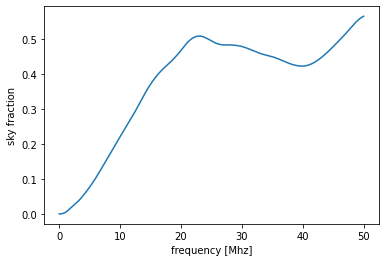

In [3]:
f=np.logspace(-2,np.log10(50.),1000)
plt.plot(f,sky_frac(f))
plt.xlabel('frequency [Mhz]')
plt.ylabel ('sky fraction')

Text(0, 0.5, 'P [K]')

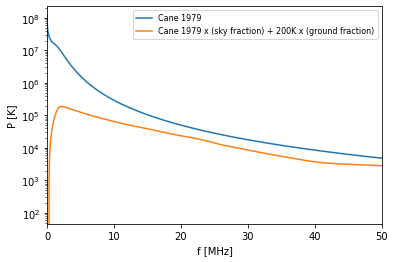

In [4]:
T_sky = lusee.monosky.T_C(f).value
T_ant = sky_frac(f)*T_sky + ((1-sky_frac(f))*200)

plt.plot(f,T_sky, label= 'Cane 1979')
plt.plot(f,T_ant, label= 'Cane 1979 x (sky fraction) + 200K x (ground fraction)')
plt.semilogy()
plt.xlim(0,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('P [K]')

# Antenna Loading: plasma effects

We will load the plasma effects from Bale, which are already expressed in units of ${\rm V^2/Hz}$.
They are only available at frequencies less than 10Hz.

Text(0, 0.5, '$P_{\\rm plasma}$ [V^2/Hz]')

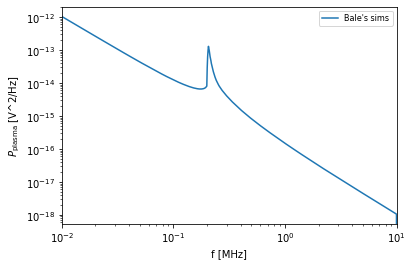

In [5]:
T=lusee.Throughput(beam)

P_plasma = np.zeros_like(f)
P_plasma[f<10] = lusee.monosky.BalePlasmaEffects()(f[f<10])

plt.plot(f,P_plasma, label= "Bale's sims")
plt.loglog()
plt.xlim(0.01,10)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$P_{\\rm plasma}$ [V^2/Hz]')

# Signal level as seen by the JFET

The power spectrum at the JFFET is given by 

$$
P_{\rm jfet} = \Gamma^2_{VD} \left( 4 \Re(Z_{\rm ant}) k_b T_{\rm ant}  + P_{\rm plasma}  \right) + P_{\rm noise}
$$

where the voltage divider coupling is given by

$$
\Gamma^2_{VD} = \frac{|Z_{\rm rec}|^2}{|Z_{\rm rec}+Z_{\rm ant} |^2}
$$

and $Z_{\rm rec} = \left(i \omega C_r + R_r^{-1}\right)$, where $C_r=35\,{\rm pF}$ and $R_r=10^4\,\Omega$ and $Z_{\rm ant} is whatever comes out simulations.

In this work we assume noise to be $P_{\rm noise} = (2\,{\rm nV}/\sqrt{{\rm Hz}})^2$.

array([-0.-50377.83707359j])

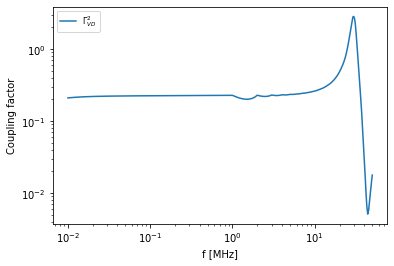

In [6]:
T=lusee.Throughput(beam)
plt.plot(f,T.Gamma_VD(f)**2,label= "$\Gamma_{VD}^2$")
plt.loglog()
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('Coupling factor')
T.AntennaImpedanceInterp(np.array([0.1]))

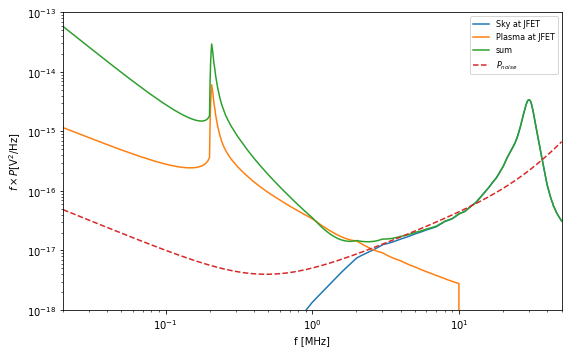

In [8]:
P_sky_jfet = T_ant * T.T2Vsq(f)
P_plasma_jfet  = P_plasma*T.Gamma_VD(f)**2
plt.figure(figsize=(8,5))
plt.plot(f,f*P_sky_jfet, label= 'Sky at JFET')
plt.plot(f,f*P_plasma_jfet, label= 'Plasma at JFET')
plt.plot(f,f*P_sky_jfet+P_plasma_jfet, label= 'sum')
plt.plot(f,f*T.noise(f),'--',label='$P_{noise}$')
plt.loglog()
plt.xlim(0.02,50)
plt.ylim(1e-18,1e-13)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$f \\times P [{\\rm V^2/Hz}]$')
plt.tight_layout()
plt.savefig('total_signal.pdf')

# From JFET to ADC

We now load in the gain curves and multiply the signal at the JFET to get the signal at the ADC input.

Text(0, 0.5, 'gain[dB]')

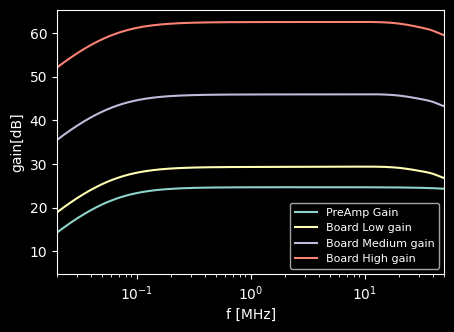

In [71]:
plt.plot(f,np.log10(np.abs(T._preamp_gain(f)**2))*10, label= 'PreAmp Gain')
plt.plot(f,np.log10(np.abs(T._gain["L"](f)**2))*10, label= 'Board Low gain')
plt.plot(f,np.log10(np.abs(T._gain["M"](f)**2))*10, label= 'Board Medium gain')
plt.plot(f,np.log10(np.abs(T._gain["H"](f)**2))*10, label= 'Board High gain')

plt.semilogx()
plt.xlim(0.02,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('gain[dB]')

Text(0, 0.5, 'Arg amplitude gain [radians]')

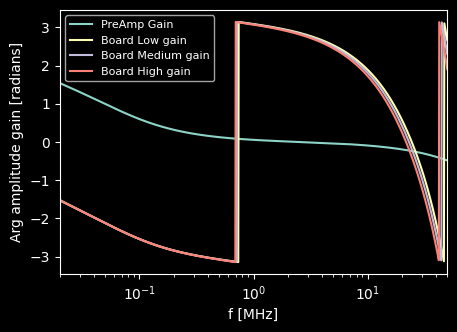

In [72]:
plt.plot(f,np.angle(T._preamp_gain(f)), label= 'PreAmp Gain')
plt.plot(f,np.angle(T._gain["L"](f)), label= 'Board Low gain')
plt.plot(f,np.angle(T._gain["M"](f)), label= 'Board Medium gain')
plt.plot(f,np.angle(T._gain["H"](f)), label= 'Board High gain')

plt.semilogx()
plt.xlim(0.02,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('Arg amplitude gain [radians]')

In [73]:
gain = T.power_gain(f,'M')

In [74]:
P_sky_adc = P_sky_jfet * gain
P_plasma_adc = P_plasma_jfet * gain
P_total_adc = P_sky_adc + P_plasma_adc
P_noise_adc = T.noise(f) * gain

Text(0, 0.5, '$f \\times P [{\\rm V^2/Hz}]$')

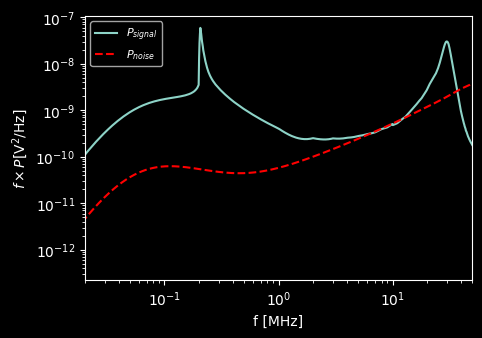

In [75]:
plt.plot(f,f*P_total_adc,'-',label='$P_{signal}$')
plt.plot(f,f*P_noise_adc,'r--',label='$P_{noise}$')
plt.loglog()
plt.xlim(0.02,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$f \\times P [{\\rm V^2/Hz}]$')



# Signal variances in the adc units

To get the total signal variance we integrate power in units of ${\rm V^2/Hz}$ over the bandwidth of the channel.

$$

\sigma^2_{\rm total} = \int P (f) df

$$

This results in variance in units of V. We can than compare this with the ADC range.


In [76]:
def Pv2rms(Pv):
    rms = np.sqrt(simpson(Pv,f*1e6)) #1e6 converts MHz to Hz
    return rms

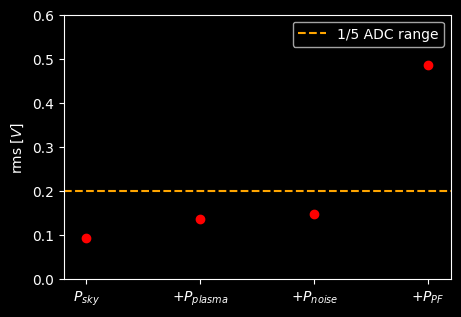

In [77]:
rms_sky = Pv2rms(P_sky_adc)
rms_add_plasma = Pv2rms(P_sky_adc+P_plasma_adc)
rms_add_noise = Pv2rms(P_sky_adc+P_plasma_adc+P_noise_adc)
# assume PF is 5 times in amplitude as the sky
P_PF_adc = P_sky_adc*5**2
rms_add_PF = Pv2rms(P_sky_adc+P_plasma_adc+P_noise_adc+P_PF_adc)
plt.plot(1,rms_sky,'ro')
plt.plot(2,rms_add_plasma,'ro')
plt.plot(3,rms_add_noise,'ro')
plt.plot(4,rms_add_PF,'ro')
plt.xticks([1,2,3,4],['$P_{sky}$','$+P_{plasma}$','$+P_{noise}$','$+P_{PF}$'])
plt.ylabel('${\\rm rms}\ [V]$')
# now the full ADC range is 2V, so -1V to +1V. 
# and the 1/5 of ADC range (so that 5 sigma events saturate) is at 0.2V
plt.axline((0,1/5),slope=0,ls='--',color='orange',label='1/5 ADC range')
plt.xlim(0.8,4.2)
plt.ylim(0,0.6)
plt.legend()


# Sanity check: noise only
Here we use white noise or noise from Emi's file

Text(0, 0.5, '$f \\times P [{\\rm V^2/Hz}]$')

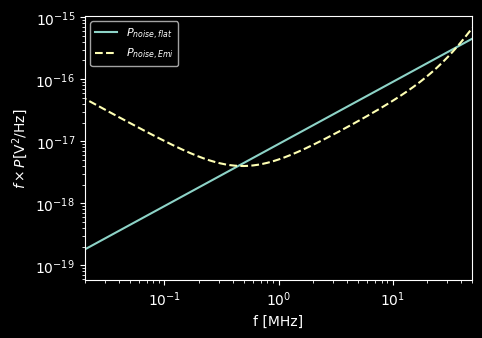

In [78]:
Pnoise_flat = (3e-9)**2*np.ones_like(f)
Pnoise_emi = T.noise(f)
plt.plot(f,f*Pnoise_flat,'-',label='$P_{noise, flat}$')
plt.plot(f,f*Pnoise_emi,'--',label='$P_{noise, Emi}$')
plt.loglog()
plt.xlim(0.02,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$f \\times P [{\\rm V^2/Hz}]$')

Text(0, 0.5, '$P [{\\rm V^2/Hz}]\\, {\\rm\\ at\\ ADC}$')

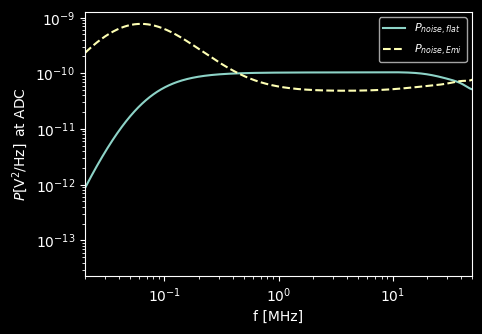

In [79]:
Pnoise_flat_adc = Pnoise_flat * gain
Pnoise_emi_adc = Pnoise_emi * gain
plt.plot(f,Pnoise_flat_adc,'-',label='$P_{noise, flat}$')
plt.plot(f,Pnoise_emi_adc,'--',label='$P_{noise, Emi}$')
plt.loglog()
plt.xlim(0.02,50)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$P [{\\rm V^2/Hz}]\, {\\rm\ at\ ADC}$')


In [80]:

Pnoise_flat_adc_rms = Pv2rms(Pnoise_flat_adc)
Pnoise_emi_adc_rms = Pv2rms(Pnoise_emi_adc)
print ("RMS flat = ",Pnoise_flat_adc_rms,"V")
print ("RMS emi = ",Pnoise_emi_adc_rms,"V")

RMS flat =  0.06491392088233791 V
RMS emi =  0.05677892903597014 V


In [81]:
gain2db = lambda gain: np.log10(np.abs(gain**2))*10
gain2db(T._gain["M"](10)),gain2db(T._preamp_gain(10))


(45.966426707362196, 24.664869183086196)

In [83]:
rms_naive_M = np.abs(3e-9*T._gain["M"](10)*np.sqrt(50e6))
rms_naive_preamp_M = np.abs(3e-9*T._preamp_gain(10)*T._gain["M"](10)*np.sqrt(50e6))
print ("RMS naive M = ",rms_naive_M,"V")
print ("RMS naive preamp+M = ",rms_naive_preamp_M,"V")

RMS naive M =  0.004216262019429002 V
RMS naive preamp+M =  0.07213915508211881 V
